In [ ]:
%%capture
# Packages for topic modelling
!pip install top2vec[sentence_encoders]
!pip install chatintents
!pip install bertopic
!pip install kaleido

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import ast

# For DR/clustering
import umap
import hdbscan

# Emotion
from transformers import pipeline

# Topic models
from chatintents import ChatIntents
from bertopic import BERTopic
from top2vec import Top2Vec

# Text pre-processing
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.preprocessing import normalize
nltk.download('wordnet')
nltk.download('stopwords')

# Mini LM sentence embeddsing
from sentence_transformers import SentenceTransformer
emb_model_mini = SentenceTransformer("all-MiniLM-L6-v2")

# USE embedding
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

emb_model_use = hub.load(module_url)
print ("module %s loaded" % module_url)

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Emotion and Topic

File to get the emotions and topics per message.

Ther may still be some additional cleaning, rather pre-processing of text messages.

__Reminder__

There are currently two sentence embedding models, both transformer based, I use:

1. USE: universal sentence endocer, embedding size 512
1. all-MiniLM-L6-v2: embedding size 384


In [ ]:
# Load data (here load clean and GPT translated emotion)
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_translation_gpt_3-5.csv')

In [ ]:
df['message_final'].count()

2351

## Pre-processing

For now, steps are limited to a bare minimum. Can explore how results change if applying pre-procesing. For emotions my guess is that there is no much change as the model has its own pre-processing. For topic models it may change indeed.

__Pre-processing__

So far text pre-processing before creating embeddings has not shown any major improvements. I tried removing stopwords and punctuation. But I could still consider pre-processing steps, specifically: stopwords removal, lemmatisation.

__Cleaning__

Basic cleaning may improve results. I removed "Photo: name1, name2, ..." which I found for some messages. This part mentionds the photographers of pictures, and the cluster algorithm picked up on this, hence I removed it.

$⇒$ add more cleaning when I find instances to clean

__NOTE__: this has been done after the translation task!!

In [ ]:
# Final messages to list, without any pre-processing
messages_clean = df['message_final'].to_list()

In [ ]:
# Examples to show removal worked
#print(messages[2])
print(messages_clean[2])

I met with the President of the Japanese International Cooperation Agency, JICA, Akihiko Tanaka.

We discussed the priority areas of JICA's activities in Ukraine. We have a special interest in involving Japan in the production of demining equipment, the development of a network of rehabilitation centers for veterans and military personnel, as well as the production of energy equipment.

We appreciate the practical assistance provided by JICA in the recovery of our state and the implementation of projects to support key sectors of the national economy. Thank you for your willingness to actively participate in the preparation of the Conference on the Reconstruction of Ukraine.


__Top n words__

Below I just want to check the most distinctive words using tf-idf.

I use column sum, to get the word score to get the aggregated importance of words (compared to their mean importance).

In [ ]:
# Quick view on the most distinctive words of the corpus
def top_n_words(corpus, n):

  tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
  # Resulting matrix is of shape: (n docs, types) and the values are tf-idf weighted counts
  tfidf_matrix = tf_idf_vectorizer.fit_transform(corpus)

  # Word scores = sum of columns (not too sure about it, can also use mean?)
  # Check the lecture slide for supervised sclaing, and columns are summed
  word_scores = np.sum(tfidf_matrix.toarray(), axis=0)
  sorted_indices = np.argsort(word_scores)[::-1] # sorts word score, outputs indices
  feature_names = tf_idf_vectorizer.get_feature_names_out()
  return feature_names[sorted_indices][:n] #, word_scores[sorted_indices][:n]


top_n_words(messages_clean, 50)

array(['ukraine', 'people', 'thank', 'russian', 'ukrainian', 'war',
       'world', 'russia', 'support', 'state', 'defense', 'glory', 'today',
       'day', 'victory', 'country', 'freedom', 'peace', 'important',
       'ukrainians', 'security', 'discussed', 'region', 'minister',
       'europe', 'european', 'meeting', 'grateful', 'president',
       'occupiers', 'life', 'prime', 'enemy', 'international', 'land',
       'new', 'time', 'aggression', 'work', 'situation', 'united',
       'lives', 'forces', 'soldiers', 'military', 'fight', 'defend',
       'help', 'countries', 'terror'], dtype=object)

## Topic Model

To get topics, I use two approaches:

### Own approach

The inital plan was to create universal encoder embeddings, and the using DBSCAN or OPTICS to find cluster. However, I could only get one or just few incorrect clusters (other clusters were just two identical texts). There are mutliple reasons for this: HDBSCAN classifies all embeddings as outliers, indicating the algorithm does not find cluster in the high dimensionality. The solution to this was to reduce the dimension fo the USE embedding from a 512 to a low-dimension embedding using dimensionality reduction techniques (UMAP appears to be state-of-the-art). With low-dimensional embeddings, HDBSCAN now finds clusters but very few only. What has a huge effect on the results is the selection of hyperparamters.

#### Hyperparamter tuning

1. Embeddings

  *   Model: Not really a hyperparamter, but I could try different embeddings (e.g. OpenAI's ada model)
  *   Normalisation: Decide to use normalisation or not $→$ currently it looks like normalisation is needed, i.e. unit norm

2.  UMAP

  *   `n_neighbor`: size of neighbourhood when learning the structure of data. Low values mean UMAP focuses on local structures, and vice versa. Low values potentially leads UMAP to not see more global structures of chains of clusters. Increasing the parameter lets UMAP "glue" together different parts of the data (default: 15)

  *   `min_distance`: minimum distance between points in the low-embedding space, determines how compact points are packed. Smaller values makes points more compact, and larger more spread-out. (default: 0.1)

  *   `n_components`: dimensions to project the data to (default: 5)

3. HDBSCAN

  *   `min_cluster_size`: smallest size to consider a cluster [my idea is that this should be around 15-30 to allow 133 to 66 topics in extreme cases]. Default: 5

  *   `min_samples`: has a strong effect (!). The larger the more points will be declared as noise, and clusters will be restricted to be more dense. Default: equal to min cluster size if not specified

  *   `cluster_selection_epsilon`: do not split clusters lower than this value. Smaller values will results in more fine-grained clusters, and vice versa. Larger values merge small sub-clusters in to larger ones.

    *   Reduce dimension of embeddings, eg, UMAP and tune paramters
    *   Reduce parameter of cluster distances, ie, DBSCAN HP tuning (or use HDBSCAN as top2vec)
    *   Different pre-processing

#### chat-intents

A library for hyperparamter tuning of UMAP and HDBSCAN.

tba

---

### Top2Vec

A library that creates document and word embeddings in one space. Then finds document clusters, and gets distinct word embeddings to describe clusters.

Essentially needs the same HP tuning as I do in my own approach. Thus currently proceeding here as HP of above will be crucial.

---

### BERTopic

tba

---

### Validation

Important (!) to make the creation of topics plausible and not look like an arbitrary selection of topics.

I think here the `chat-intents` package provides a defensible way of selecting hyperparameters of both UMAP and HDBSCAN.

Measures to think about:

*   Topic coherenece and diversity: see BERTopic paper. These are commonly used metrics to asses topic models.
*   Silhouette Score: see GPT chat "HDBSCAN Noise Handling", but as argued in the TDS article about HP tuning, this mught not be the best score, because the score assumes or points are assigned to a group, without outliers.
*   OCTIS, see git issue of https://github.com/MaartenGr/BERTopic/issues/437


---

### General notes/observations/best practices

*   GPT and UMAP FAQ argue to better to scaled data, hence I focus on normalisd embeddings
*   Trying other cluster algorithms than HDBSCAN (MeanShift, OPTICS), all only create one cluster when using (normalised) embeddings -> this leads me to reduce dimensions first
*   As I will run a regression using topic as a cat variable, I should keep in mind to have enough observations for each topic. Thus, `min_cluster_size` should be large enough.
*   Interesting idea to use R2 for validation: https://arxiv.org/abs/1911.11061


### Topic modelling (own approach)

Idea follows state-of-the-art topic models (Top2Vec and BERTopic) that use cluster algorithms. The procedure is as follows:

1.   Embeddings: get embeddings on sentence level
2.   Dimensions reduction: due to the size of the embedding, I reduce the dimension of each
3.   Clustering: HDBSCAN to cluser documents of low-dimensional embedding

---

__Comparison to packages__

I looked through the implementations of BERTopic and chat-intents, and used their HP and embeddings for my own approach. I could almost identically replicate the results I obtained from the packags.

Hence, an idea is to tune, rather qualitatively optimise HP, and then use those in the packages, in particualr BERTopic.



In [ ]:
# Load data
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_emotions_bert.csv')

__First__, get embeddings. Here I use USE and allMini, and for both I normalise, thus in total there are 4 embedding choices.

In [ ]:
# 1. Get universal encoder sentence embeddings
mess_emb_use = emb_model_use(messages_clean)
mess_emb_use_norm = normalize(mess_emb_use, norm='l2')

# 2. Get universal encoder sentence embeddings
mess_emb_mini = emb_model_mini.encode(messages_clean, show_progress_bar=True)
mess_emb_mini_norm = normalize(mess_emb_mini, norm='l2')

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

__Second__, use UMAP to reduce the size of the embedding. Is sensitive to HP.

In [ ]:
# 2. Reduce embeddings
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=16).fit_transform(mess_emb_mini_norm)

__Third__, use HDBSCAN to cluster low-dimensional embeddings from UMAP. Also sensitive to HP.

In [ ]:
# 3. Find clusters
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          min_samples=5,
                          #cluster_selection_epsilon=0.01,
                          cluster_selection_method='eom',
                          metric='euclidean').fit(umap_embeddings)

#### Summary and visualisaiton

Below computes summaries for the above approach.

In [ ]:
# Summary
np.unique(cluster.labels_, return_counts = True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([698,  22,  37,  49,  37,  28,  37,  28, 100,  34,  46,  37,  69,
         35,  40,  30, 139,  84, 165,  23,  23,  20,  34,  36,  43,  55,
        102,  34,  35]))

In [ ]:
# Create df with topic label which are the top n words by topic using tf-idf (ie cluster tf-idf)
def get_df_by_topic(messages):
  docs_df = pd.DataFrame(messages, columns=['Message'])
  docs_df['Topic'] = cluster.labels_
  docs_df['Doc_ID'] = range(len(docs_df))
  docs_per_topic = docs_df.groupby(['Topic'],
                                as_index = False).agg({'Message': ' '.join})
  return docs_per_topic

def get_most_frequent_words(row, n_words=10):

  # Get words
  words = nltk.word_tokenize(row['Message'])

  vectorizer = TfidfVectorizer(stop_words='english',
                                ngram_range = (1,2))

  tfidf_matrix = vectorizer.fit_transform(words)
  feature_names = vectorizer.get_feature_names_out()
  word_scores = tfidf_matrix.sum(axis=0).A1
  word_scores_dict = dict(zip(feature_names, word_scores))
  sorted_words = sorted(word_scores_dict.items(), key=lambda x: x[1], reverse=True)

  return sorted_words[:n_words]

df_topic = get_df_by_topic(messages_clean)
df_topic['freq_words'] = df_topic.apply(get_most_frequent_words, axis=1)


In [ ]:
for index, row in df_topic.iterrows():
  print(row['Topic'], ' ;'.join([x[0] for x in row['freq_words']]))

-1 ukraine ;russian ;people ;ukrainian ;russia ;war ;world ;state ;thank ;defense
0 nuclear ;iaea ;russian ;ukraine ;world ;plant ;power ;station ;npp ;ukrainian
1 ukraine ;reconstruction ;world ;investment ;economic ;state ;war ;ukrainian ;discussed ;important
2 war ;interview ;ukraine ;media ;ukrainian ;world ;countries ;channel ;important ;occupiers
3 ukraine ;united24 ;platform ;world ;support ;fundraising ;people ;help ;ambassadors ;u24_gov_ua
4 ukraine ;minister ;prime ;defense ;rishi ;sunak ;support ;uk ;discussed ;united
5 ukraine ;support ;states ;united ;president ;congress ;people ;important ;thank ;biden
6 food ;ukraine ;grain ;security ;world ;global ;initiative ;countries ;people ;russia
7 ukraine ;support ;peace ;discussed ;defense ;president ;ukrainian ;minister ;formula ;cooperation
8 sanctions ;russia ;russian ;ukraine ;today ;state ;war ;european ;world ;terror
9 ukraine ;european ;europe ;eu ;union ;freedom ;thank ;people ;membership ;support
10 ukraine ;nato ;secur

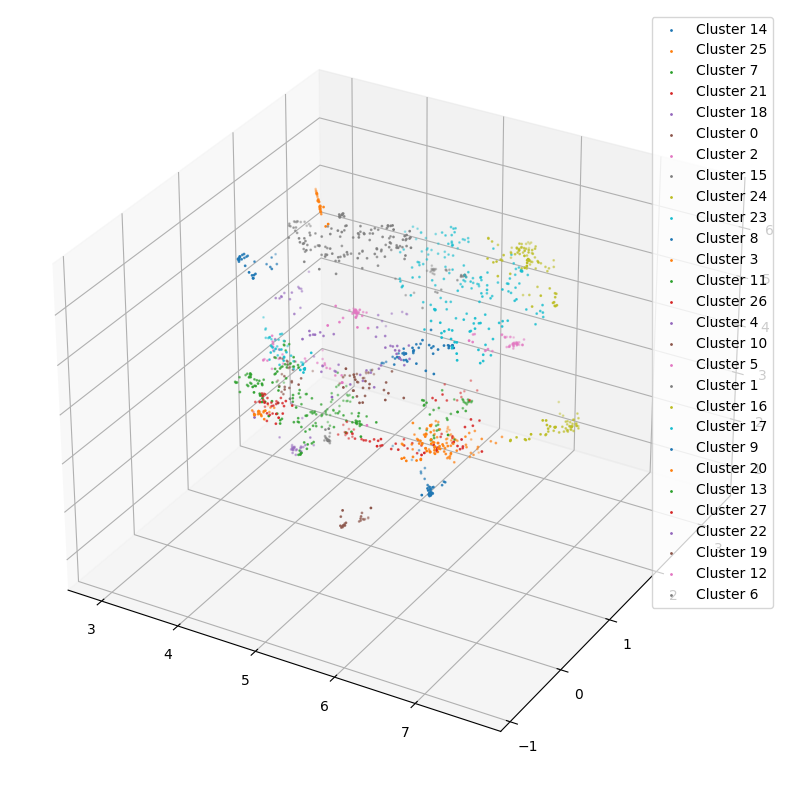

In [ ]:
# 3D vis of topics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def vis_3D(embeddings):
  umap_data = umap.UMAP(n_neighbors=15,
                            n_components=3,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=16).fit_transform(embeddings)
  result = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
  result['labels'] = cluster.labels_

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  #ax.scatter(outliers.x, outliers.y, outliers.z, color='#0d0000', s=1)

  for label in clustered.labels.unique():
      cluster_data = clustered[clustered.labels == label]
      ax.scatter(cluster_data.x, cluster_data.y, cluster_data.z, label=f'Cluster {label}', s=1, cmap='hsv_r')

  ax.legend()

  plt.show()

vis_3D(mess_emb_mini_norm)

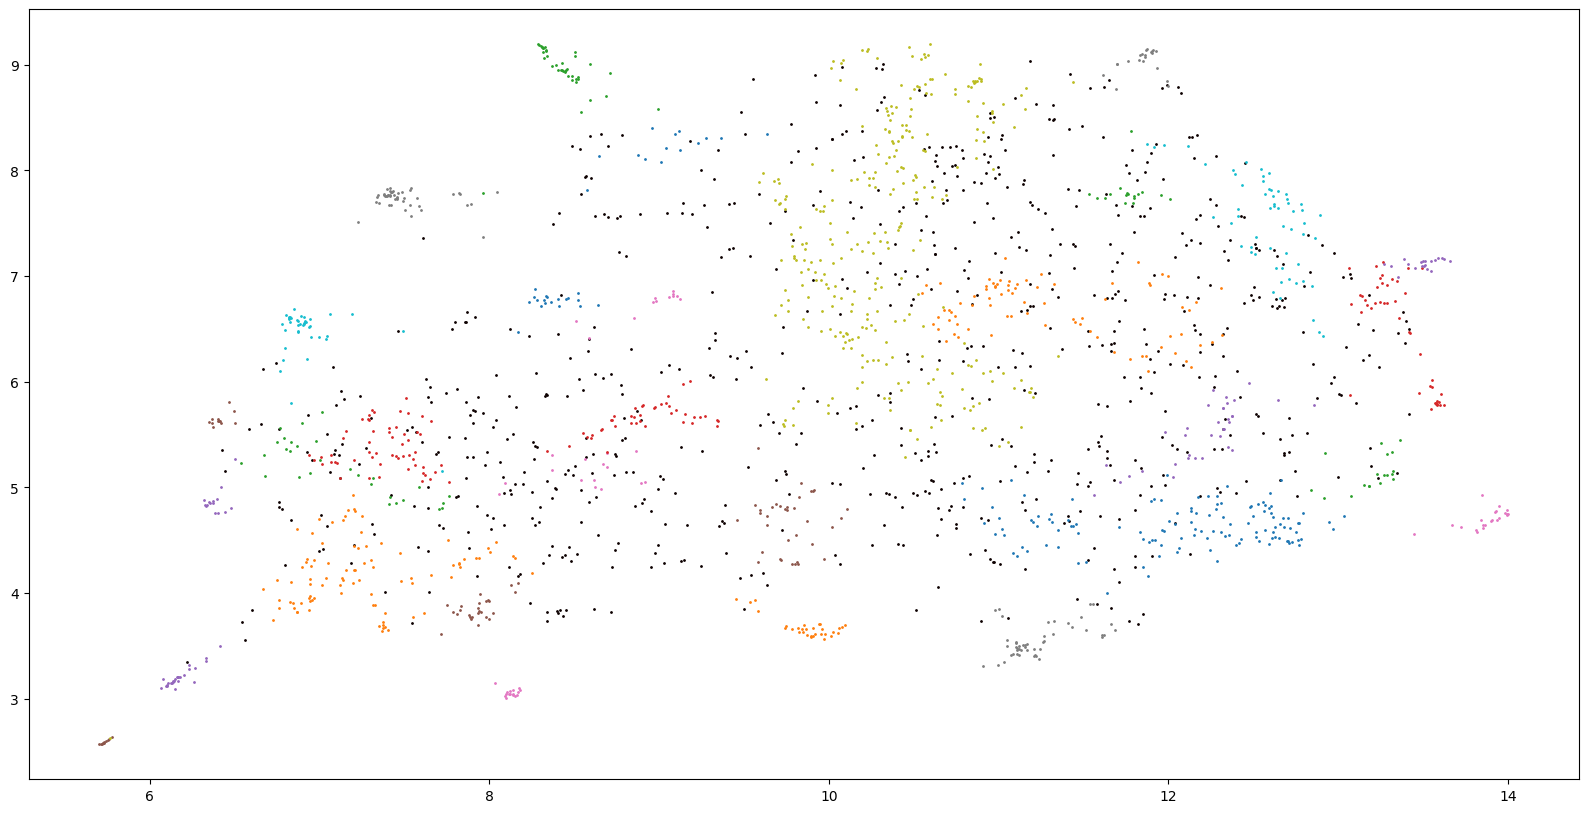

<Figure size 7680x5760 with 0 Axes>

ValueError: ignored

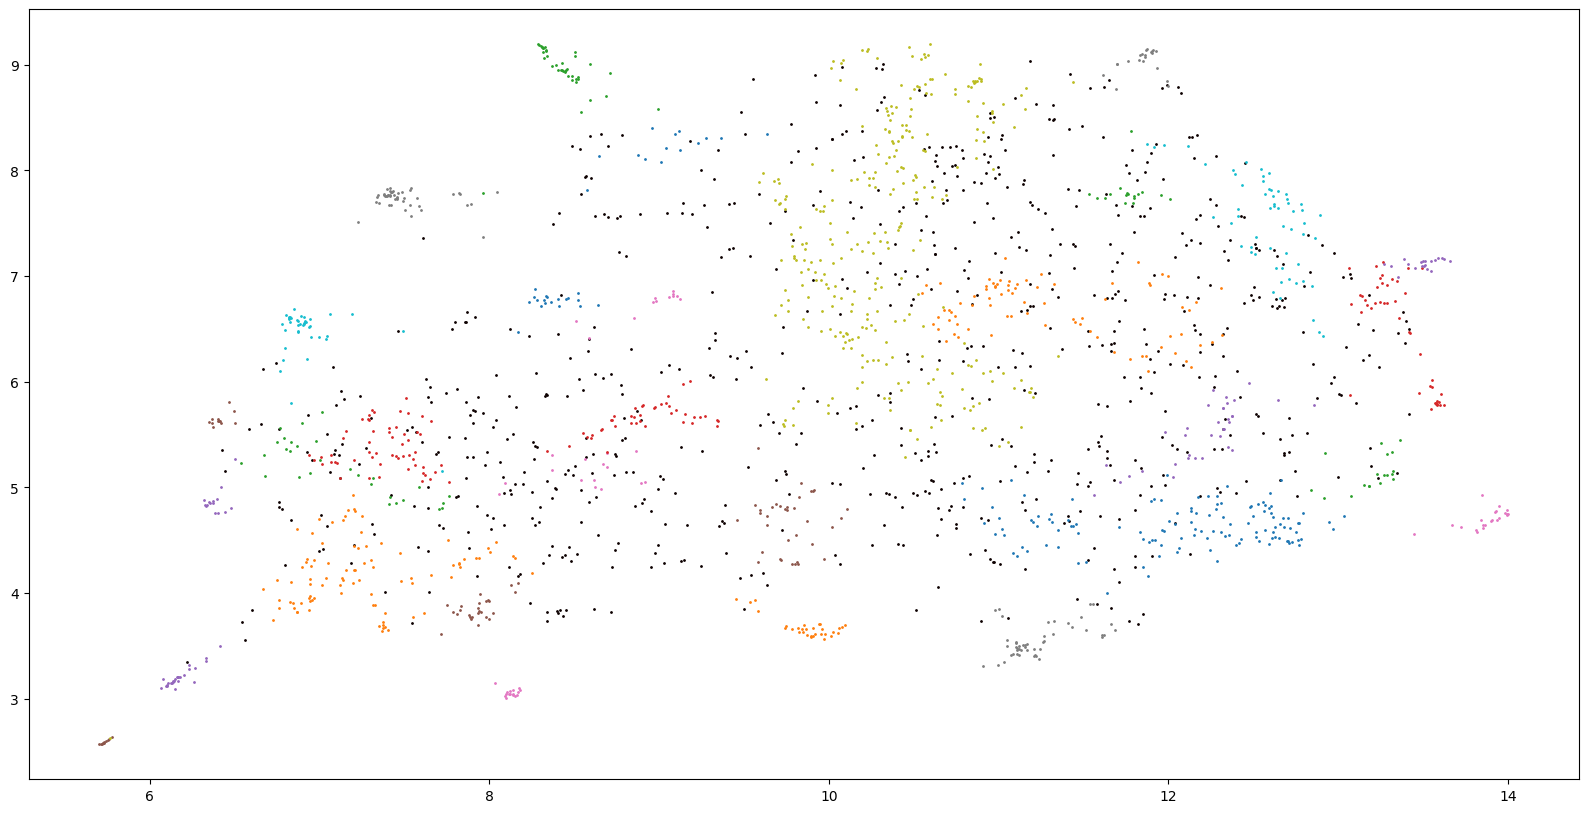

<Figure size 7680x5760 with 0 Axes>

In [ ]:
# 2D vis of topics
def vis_2D(embeddings):
  umap_data = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        min_dist=0.0,
                        metric='cosine').fit_transform(embeddings)
  result = pd.DataFrame(umap_data, columns=['x', 'y'])
  result['labels'] = cluster.labels_

  fig, ax = plt.subplots(figsize=(20, 10))
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  plt.scatter(outliers.x, outliers.y, color='#0d0000', s=1)

  for label in clustered.labels.unique():
      cluster_data = clustered[clustered.labels == label]
      plt.scatter(cluster_data.x, cluster_data.y, label=f'Cluster {label}', s=1, cmap='hsv_r')

  # Add a legend
  #plt.legend()

  plt.figure(dpi=1200)
  plt.show(mess_emb_mini_norm)

vis_2D(mess_emb_mini_norm)

### Top2Vec

Can select between different embedding models. Without tuning any hyperparamter the default is doc2vec (gives 7 topic), an alternative is the universal sentence encoder (gives 16 topics).

In [ ]:
# Model summariesd
def model_summary(model, note:str):
  print('Model:', note)
  print('N topics:', model.get_num_topics())
  print('Topic distributions:')
  topic_sizes, topic_nums = model.get_topic_sizes()
  topic_words, word_scores, topic_nums = model.get_topics()

  print('Topic distribution and words:')
  for i in range(len(topic_words)):
    print(f' Topic {i}: {topic_sizes[i]}')
    print(' ', '; '.join(topic_words[i][:10]))

In [ ]:
# Run model with doc2vec, and default delta
model_d2v = Top2Vec(messages,
                    speed="learn",
                    workers=8) # embedding_model='universal-sentence-encoder'

2023-06-17 15:52:26,823 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-06-17 15:52:27,986 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 15:52:45,885 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-17 15:53:12,423 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-17 15:53:12,542 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_summary(model_d2v, 'd2v; default delta')

Model: d2v; default delta
N topics: 5
Topic distributions:
Topic distribution and words:
 Topic 0: 986
  many; is; feel; when; have; over; these; and; whole; which
 Topic 1: 516
  agreed; reconstruction; spoke; talked; relations; package; conversation; current; aid; start
 Topic 2: 230
  petrov; times; serhii; path; korovainyi; photo; images; liberov; kostiantyn; liberova
 Topic 3: 207
  ammunition; also; course; work; attention; in; information; military; towards; was
 Topic 4: 182
  soldiers; warriors; defenders; enemy; fighters; bakhmut; like; brigade; intelligence; would


In [ ]:
# Run model witht the universal sentence encoder
model_use = Top2Vec(messages,
                    speed="learn",
                    workers=8,
                    embedding_model='universal-sentence-encoder')

2023-06-17 15:53:12,671 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-06-17 15:53:15,638 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-06-17 15:53:25,799 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 15:53:27,648 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-17 15:53:40,032 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-17 15:53:40,104 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_summary(model_use, 'universal sentence encoder; default delta')

Model: universal sentence encoder; default delta
N topics: 2
Topic distributions:
Topic distribution and words:
 Topic 0: 2045
  ukrainians; donetsk; kyiv; ukraine; ukrainian; crimea; kharkiv; nato; petrov; russia
 Topic 1: 76
  nuclear; crimea; petrov; donetsk; ukraine; kyiv; russia; sanctions; missiles; ukrainians


#### Fine-tuning

HP to fine-tune:


*   Embedding model: doc2ve, universal-sentence encoder (word2vec architecture vs transformers)
*   `topic_merge_delta`: merges topic vectors with a cosine distance smaller than specified (default 0.1)
*   Change data pre-processing
*   See `compute_topics` function
*   Pre-processing: default uses gensim.utils.simple_preprocess' including lowercaseing and tokenizing.
*   UMAP: dimension reduction HP (see page)
*   HDBSCAN: cluster HP (see page)




##### __Hyperparamters__

UMAP:

HDBSCAN:

DBSCAN:

In [ ]:
# Run model witht the universal sentence encoder
model_use_d = Top2Vec(messages,
                     speed="learn",
                    workers=8,
                    topic_merge_delta = 0.01)

2023-06-17 15:53:40,170 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-06-17 15:53:40,667 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 15:53:54,598 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-17 15:54:06,586 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-17 15:54:06,659 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_summary(model_use_d, 'universal sentence encoder; lower delta')

Model: universal sentence encoder; lower delta
N topics: 3
Topic distributions:
Topic distribution and words:
 Topic 0: 1451
  and; real; the; soon; is; long; next; in; we; on
 Topic 1: 366
  remember; lives; fight; ukrainians; those; eternal; definitely; land; closer; gave
 Topic 2: 304
  ammunition; equipment; at; actions; in; general; both; directions; held; very


In [ ]:
# See effect of topic_merge_delta on number of topics
deltas = np.linspace(0.01, .1, 10).tolist()
deltas

[0.01,
 0.020000000000000004,
 0.030000000000000006,
 0.04000000000000001,
 0.05000000000000001,
 0.06000000000000001,
 0.07,
 0.08,
 0.09000000000000001,
 0.1]

In [ ]:
# See effect of topic_merge_delta on number of topics

deltas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
n_topics = []
for d in deltas:
  model = Top2Vec(messages,
                    speed="learn", workers=8,
                    topic_merge_delta=d) # embedding_model='universal-sentence-encoder'

  n_topics.append(model.get_num_topics())



2023-06-17 15:54:06,737 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-06-17 15:54:07,233 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 15:54:20,735 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-17 15:54:31,983 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-17 15:54:32,049 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-06-17 15:54:32,079 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-06-17 15:54:32,625 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 15:54:49,268 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Crea

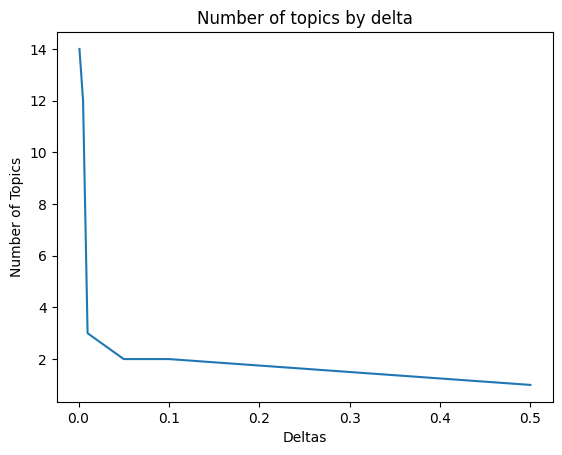

In [ ]:
# Visualise topic number per delta
plt.plot(deltas, n_topics)
plt.xlabel('Deltas')
plt.ylabel('Number of Topics')
plt.title('Number of topics by delta')
plt.show()

##### Pre-processing

In [ ]:
# Pre-processing: remove stopwords and punctuation
stop_words = stopwords.words('english')
def pre_process(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  words = nltk.word_tokenize(text)
  words = [word.lower() for word in words if word.lower() not in stop_words]

  return ' '.join(words)

messages_prepro = [pre_process(m) for m in messages]
messages_prepro[0]

'finished late always productive conversation andrzej duda discussed expectations nato summit vilnius understand importance strong steps taken alliance regarding security guarantees ukraine thank strong defense support poland priority needs front also discussed thank andrzej strong unwavering stance'

In [ ]:
# Run model on messages without stopwords
model_prepro = Top2Vec(documents=messages,
                       speed="learn",
                       workers=8,
                       embedding_model='universal-sentence-encoder',
                       umap_args={'n_neighbors': 5,
                                  'n_components': 5,
                                  'min_dist': 0.5,
                                  'random_state': 42,
                                  'metric': 'euclidean'},
                       hdbscan_args={'min_cluster_size': 20,
                                     'min_samples': 1,
                                      'cluster_selection_epsilon': .01})

2023-06-17 19:44:09,841 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

2023-06-17 19:44:10,993 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-06-17 19:44:23,276 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-17 19:44:25,032 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-17 19:44:35,206 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-17 19:44:35,339 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
print(model_prepro.get_num_topics())
model_summary(model_prepro, 'doc2vec; default d; pre-processed messages')

2
Model: doc2vec; default d; pre-processed messages
N topics: 2
Topic distributions:
Topic distribution and words:
 Topic 0: 2031
  ukrainians; donetsk; kyiv; ukraine; ukrainian; crimea; kharkiv; nato; petrov; russia
 Topic 1: 90
  nuclear; crimea; petrov; donetsk; ukraine; kyiv; sanctions; russia; missiles; ukrainians


### BERTopic

add explanations

---

__Default parameters__

1. Embedding: uses MiniAll embeddings as default, can use others as well

2. UMAP:

```
n_neighbors=15,
n_components=5,
min_dist=0.0,
metric='cosine'
```

3. HDBSCAN:

```
min_topic_size: int = 10,
```

Note: as I would like to have enough support for each level of topis in the regression, I should think about increasing this parameter.

---

#### Simple model

This runs BERTopic as it is. Later I qualitatively tune paramters.

In [ ]:
# Initalise mode
bert_model = BERTopic()

In [ ]:
# Fit model
topics, probs = bert_model.fit_transform(messages_clean)

@Mini: bert_model.topic_embeddings_

Here you can fine-tune modules of the model. For example, choose a different vectoriser, here, removing stopwords and inlcuding n-grams.

Should I use **lemmatisation**? Motivation: the topic words are often similar (crime, crimes, criminals). Hence getting word lemmas may reveal more about the cluster, as we get more distinct words.


In [ ]:
# Fine-tune topic representation, this does not influence clusters!!
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=10)
topic_model.update_topics(messages_clean, vectorizer_model=vectorizer_model)

In [ ]:
topic_model.get_topic_info()[['Topic', 'Count', 'Name', 'Representation']]

,Topic,Count,Name,Representation
0,-1,807,-1_ukraine_russian_war_ukrainian,"[ukraine, russian, war, ukrainian, people, wor..."
1,0,130,0_day_glory_ukraine_ukrainian,"[day, glory, ukraine, ukrainian, people, indep..."
2,1,80,1_people_russian_terrorists_city,"[people, russian, terrorists, city, terror, te..."
3,2,78,2_free_land_matter_evil,"[free, land, matter, evil, victory, path, figh..."
4,3,74,3_europe_european_union_european union,"[europe, european, union, european union, nato..."
5,4,62,4_minister_prime minister_prime_support,"[minister, prime minister, prime, support, ass..."
6,5,58,5_media_students_war_journalists,"[media, students, war, journalists, truth, con..."
7,6,49,6_justice_crimes_international_aggression,"[justice, crimes, international, aggression, c..."
8,7,47,7_peace_russia_formula_world,"[peace, russia, formula, world, weapons, war, ..."
9,8,46,8_peace formula_formula_peace_discussed,"[peace formula, formula, peace, discussed, tha..."


#### Tuning HP

The goal is to 1) get coherent and logical cluster, which I asses up to now qualitatively. And, 2), remove the number of outliers, as a quarter of the data has been labelled as such.

A very good overview on how to fine-tune and what the implications of parameters are is given here: https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#min_cluster_size

Again, the default parameter values are:

__UMAP__
```
n_neighbors=15,
n_components=5,
min_dist=0.0,
metric='cosine'
```

*   For reproducability, I set a random state.

__HDBSCAN__

```
min_topic_size: int = 10,
```

*   I lower the `min_sample` to reduce the number of outliers, as this is a bit too high in the results.

*   I increase the number of `min_topic_size` to have enough support for the downstream regression.

__Note__:

*   The `min_sample` values is set to the `min_topic_size` if it is not specified.
*   To reduce the number of outliers, BERTopric has an own function, that uses different strategies to assign outlier docs to clusters, without changing the cluster!
---

In [ ]:
# Create UMAP and HDBSCAN models with own parameter settings:
umap_bert = umap.UMAP(n_neighbors=5,
                      n_components=5,
                      min_dist=0.0,
                      metric='cosine',
                      random_state=42)

hdbscan_bert = hdbscan.HDBSCAN(min_cluster_size=25,
                               min_samples=1)

#ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")

In [ ]:
# Initalise mode
bert_model_tune = BERTopic(umap_model = umap_bert,
                           hdbscan_model = hdbscan_bert,
                           vectorizer_model=vectorizer_model)

In [ ]:
# Fit model
topics, probs = bert_model_tune.fit_transform(messages_clean)

In [ ]:
bert_model_tune.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,540,-1_ukraine_people_war_ukrainian,"[ukraine, people, war, ukrainian, world, freed...","[Evil, unfortunately, has returned. Just like ..."
1,0,136,0_russia_russian_peace_world,"[russia, russian, peace, world, war, sanctions...",[Today is another one of our sanction days. Th...
2,1,131,1_staff_situation_defense_meeting,"[staff, situation, defense, meeting, reports, ...","[Today, the Staff held a meeting. Expanded for..."
3,2,102,2_thank_ukraine_glory_people,"[thank, ukraine, glory, people, forces, day, u...",[Please always remember that we all in Ukraine...
4,3,97,3_people_russian_building_terror,"[people, russian, building, terror, terrorists...",[The whole day was spent clearing the debris i...
5,4,91,4_occupiers_region_donbas_russian,"[occupiers, region, donbas, russian, cities, u...",[The Armed Forces of Ukraine continue to syste...
6,5,89,5_european_europe_union_eu,"[european, europe, union, eu, membership, ukra...",[\n\nThe fact that almost a year after the beg...
7,6,75,6_separate_brigade_thank_border,"[separate, brigade, thank, border, soldiers, g...",[Thank you to our soldiers who are fighting ne...
8,7,71,7_discussed_defense_formula_france,"[discussed, defense, formula, france, presiden...",[Met with President of France Emmanuel Macron....
9,8,66,8_support_minister_sweden_estonia,"[support, minister, sweden, estonia, prime, de...",[In difficult times of the struggle for freedo...


In [ ]:
def out_summary():

  with pd.option_context("max_colwidth", None):
    df_sum = bert_model_tune.get_topic_info()
    df_sum['Topic Keywords'] = df_sum['Name'].apply(lambda x: x.replace('_', '-'))
    df_sum['Example Messages'] = df_sum['Representative_Docs'].apply(lambda x: x[:2])
    df_sum['Example Messages'] = df_sum['Example Messages'].apply(lambda x: '\\tiny ' + min(x, key=len).strip()[:500])
    df_sum['Example Messages'] = df_sum['Example Messages'].apply(lambda x: x.replace('_', '-'))
    df_sum = df_sum[['Topic Keywords', 'Count', 'Example Messages']]

#    df_sum['Representative_Docs'] = df_sum['Representative_Docs'].apply(lambda x: min(x, key=len).strip()[:100])

     # Split table
    index = len(df_sum) // 2

    df1 = df_sum.iloc[:index]
    df2 = df_sum.iloc[index:]

    # Tex 1
    topic_summary_tex_1 = df1.to_latex(index=False, escape=False)
    # topic_summary_tex_1 = topic_summary_tex_1.replace('\\begin{tabular}', '\\begin{tabularx}{\\textwidth}')
    topic_summary_tex_1 = topic_summary_tex_1.replace('{lrl}', '{p{2cm}cp{11cm}}').replace('@', " ")
    topic_summary_tex_1 = topic_summary_tex_1.replace('\\toprule\n', '\\toprule\\toprule\n')
    topic_summary_tex_ = topic_summary_tex_1.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')
    # topic_summary_tex_1 = topic_summary_tex_1.replace('\\end{tabular}', '\\end{tabularx}')

    # Tex 1
    topic_summary_tex_2 = df2.to_latex(index=False, escape=False)
    # topic_summary_tex_2 = topic_summary_tex_2.replace('\\begin{tabular}', '\\begin{tabularx}{\\textwidth}')
    topic_summary_tex_2 = topic_summary_tex_2.replace('\\toprule\\n', '\\toprule\\toprule\n')
    topic_summary_tex_2 = topic_summary_tex_2.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')
    topic_summary_tex_2 = topic_summary_tex_2.replace('{lrl}', '{p{2cm}cp{11cm}}').replace('@', " ")
    # topic_summary_tex_2 = topic_summary_tex_2.replace('\\end{tabular}', '\\end{tabularx}')

    print(topic_summary_tex_1)

    with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/topics_1.tex', 'w') as file:
      file.write(topic_summary_tex_1)

    with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/topics_2.tex', 'w') as file:
      file.write(topic_summary_tex_2)

out_summary()

\begin{tabular}{p{2cm}cp{11cm}}
\toprule\toprule
                               Topic Keywords &  Count &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Example Messages \\
\midrule
              -1-ukraine-people-war-ukrainian &    540 &     \tiny Evil, unfortunately, has returned. Just like 80 years ago, evil is now making its way into our cities and villages. Although there is a different aggressor now, their goal is the same as the Nazis: enslavement or destruction. And just like in World War II, we are not alone in the fight against evil. W

---

Reduce the number of outliers with BERTopic speicifc functions.

In [ ]:
# for now i wanted to get the variable for robustness checks
new_topics = bert_model_tune.reduce_outliers(messages_clean, topics)
#bert_model_tune.update_topics(messages_clean, topics=new_topics)

In [ ]:
print(len(np.unique(topics, return_counts=True)[0]))
print(len(np.unique(new_topics, return_counts=True)[0]))

34
33


In [ ]:
topic_doc_plot = bert_model_tune.visualize_documents(messages_clean, hide_document_hover=True,
                                                     hide_annotations=True)

In [ ]:
topic_doc_plot

In [ ]:
df['topic'] = topics # topics with outliers
df['topic_no_outliers'] = df['topic'] = new_topics # topics without outliers
df.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_topics.csv', index=False)
# bert_model_tune.get_topic_info().to_excel('/content/drive/My Drive/bertopic.xlsx')